In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List
import bisect
import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import mod_protocols
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(params, x): # avg, min, max
        
    window = params['window']
    step_size = params['step_size']
    window_type = params['window_type']
        
    times = x[0]
    i_ion = x[1]
                      
    i_ion_window = []
    t = 0  
    if window_type == 'avg':
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1]                                       
            i_ion_window.append(sum(I_window)/len(I_window))  
            t += step_size     
    if window_type == 'min':
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1]                           
            i_ion_window.append(I_window.min())      
            t += step_size
    elif window_type == 'max':    
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1] 
            i_ion_window.append(I_window.max())                                                  
            t += step_size
    elif window_type == 'amax':        
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1]       
            I_window_max = I_window.max()
            I_window_min = I_window.min()            
            if abs(I_window_max) > abs(I_window_min):
                i_ion_window.append(I_window_max)                
            else : 
                i_ion_window.append(I_window_min)                                        
            t += step_size
    elif window_type == 'avg_min':
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1]                   
            i_ion_window.append([sum(I_window)/len(I_window), I_window.min()])                        
            t += step_size    
    elif window_type == 'avg_amax_min':
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1]                           
            I_window_amax = None
            I_window_max = I_window.max()
            I_window_min = I_window.min()
            if abs(I_window_max) > abs(I_window_min):
                I_window_amax = I_window_max
            else : 
                I_window_amax = I_window_min                            
            i_ion_window.append([sum(I_window)/len(I_window), I_window_amax, I_window_min])                        
            t += step_size    
    elif window_type == 'all':
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = i_ion[start_index: end_index + 1]       
            I_window_amax = None
            I_window_max = I_window.max()
            I_window_min = I_window.min()
            if abs(I_window_max) > abs(I_window_min):
                I_window_amax = I_window_max
            else : 
                I_window_amax = I_window_min                            
            i_ion_window.append([sum(I_window)/len(I_window), I_window_amax, I_window_min, I_window_max])                        
            t += step_size
            
    return i_ion_window

In [3]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.3998)

### Voltage protocol (leak_staircase)

The protocol is 15.4 s


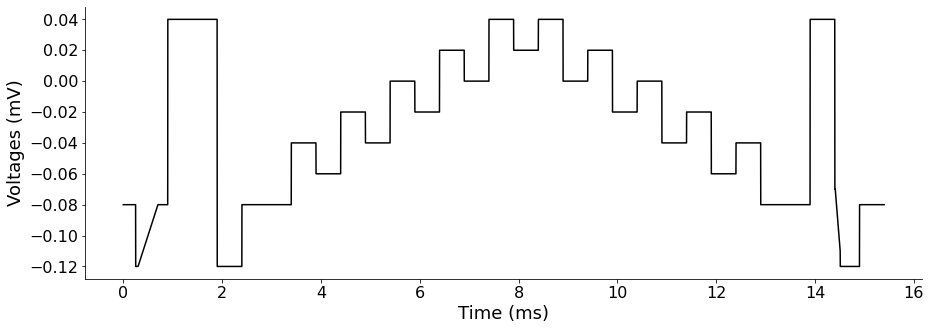

In [4]:
# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')
VC_protocol.plot_voltage_clamp_protocol(t_eval)

In [5]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],   
    't_eval' : t_eval, 
    'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
    'save_log_li' : ['ikr.IKr'],
    'nData' : 5,                             
    'dataset_dir' : f'../../Dataset/herg25oc1_real_data',
    'data_file_name' : 'IKr',
    'window' : 0.2,
    'step_size' : 0.1,
    'window_type' : 'amax'
}  
# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )

sys.path.append(gen_params['dataset_dir'])
from getdata import get_dataset, get_times

../../Dataset/herg25oc1_real_data


### Get voltages

In [6]:
voltages = np.array(VC_protocol.get_voltage_clamp_protocol(gen_params['t_eval']))*1000

### Get experimental dataset

In [7]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=1, multi=True, torch_tensor=False)  # <-- fast
times = get_times(scale=1)

The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211


In [8]:
print(xs.shape, ys.shape)

(211, 77000) (211, 9)


### Simulation setting

In [9]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=dt, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.746736764907837 seconds ---


### Check std of noise for experimental data

In [10]:
check_range = 100

std_li = []
for x in xs:    
    std_li.append(np.std(x[:check_range]))
std_li = np.array(std_li)
std_avg = std_li.mean()
std_min = std_li.min()
std_max = std_li.max()
std_argmax = std_li.argmax()
std_argmin = std_li.argmin()
print(f"min: {std_min}  |  max: {std_max}  |  avg: {std_avg}")

min: 8.346994151712211  |  max: 14.15013773648413  |  avg: 10.50049650793822


In [11]:
# VC_protocol.get_voltage_change_endpoints()

### modify experimental current

In [12]:
def get_modified_current( params, current ):  
    
    times = params['time']
    vc_protocol = params['vc']    
    neighbor_radius = params['neighbor_radius']
    
    method = params['method']
         
    pre_step = vc_protocol.steps[0]
    pre_step_index = 0
    modified_current = copy.copy(current)
    
       
    for i, t in enumerate(times):
        """Gets the voltage based on provided steps for the specified time."""
        # pre_V = VC_protocol.get_voltage_at_time(times[i-1])
        V = VC_protocol.get_voltage_at_time(t)
                        
        step_index = bisect.bisect_left( vc_protocol.get_voltage_change_endpoints(), t )
        current_step = vc_protocol.steps[step_index]
        if (pre_step_index != step_index) :
                        
            neighboring_value = current[i-10:i-1].mean()
                
            if method == 0:
                modified_current[i] = neighboring_value                    
                for j in range(1, neighbor_radius+1):
                    left_neighbor_index = i - j 
                    right_neighbor_index = i + j                 
                    modified_current[left_neighbor_index] = neighboring_value                                    
                    modified_current[right_neighbor_index] = neighboring_value                    
            elif method == 1:
                if V - VC_protocol.get_voltage_at_time(times[i-1]) > 0 :
                    for j in range( 2*neighbor_radius+1):
                        neighbor_index = i - neighbor_radius + j                     
                        if (current[neighbor_index] - neighboring_value) < -10:
                            modified_current[neighbor_index] = neighboring_value                                    
                elif V - VC_protocol.get_voltage_at_time(times[i-1]) < 0 :
                    for j in range( 2*neighbor_radius+1):
                        neighbor_index = i - neighbor_radius + j                     
                        if (current[neighbor_index] - neighboring_value) > 10:
                            modified_current[neighbor_index] = neighboring_value  

            pre_step_index = step_index
            pre_step = current_step
            
    return modified_current

In [13]:
times_vc = {
    'time' : times,
    'vc' : VC_protocol,
    'neighbor_radius' : 5,
    'method' : 0
}

get_modified_current(times_vc, xs[0])

array([-17.55719485,  15.51956915,  24.97007315, ...,   4.49398115,
       -15.98211085,   4.49398115])

In [14]:
start_time = time.time()

times_vc['method'] = 0

pool = multiprocessing.Pool(processes=os.cpu_count())
func = partial(get_modified_current, times_vc)
modified_current = pool.map(func, xs)
pool.close()
pool.join()

print("--- %s seconds ---"%(time.time()-start_time))

--- 10.221420764923096 seconds ---


In [15]:
modified_current = np.array(modified_current)
modified_current.shape

(211, 77000)

### Create a folder for results

In [16]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('"%s" has been created.'%(path))
    else:
        print("The folder already exists.")

In [17]:
dir_name = f"./modified_experimental_data_type{times_vc['method']}_w{gen_params['window']}_s{gen_params['step_size']}_{gen_params['window_type']}"
create_folder(dir_name)

"./modified_experimental_data_type0_w0.2_s0.1_amax" has been created.


### Save and show results

In [23]:
def show_results(is_plot=True, index=0):
        
    raw = {}
    raw['time'] = times
    raw['IKr'] = xs[index]
    raw['window'] = get_currents_with_constant_dt(gen_params, [times, xs[index]])
    raw['params'] = ys[index]
    print(np.array(raw['window']).shape)
    modified = {}
    modified['time'] = times
    modified['IKr'] = modified_current[index]
    modified['window'] = get_currents_with_constant_dt(gen_params, [times, modified_current[index]])
        
    model_params = {                    
        'ikr.g' : raw['params'][0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
        'ikr.p1' : raw['params'][1],
        'ikr.p2' : raw['params'][2],
        'ikr.p3' : raw['params'][3],
        'ikr.p4' : raw['params'][4],
        'ikr.p5' : raw['params'][5],
        'ikr.p6' : raw['params'][6],
        'ikr.p7' : raw['params'][7],
        'ikr.p8' : raw['params'][8],                
    } 
    sim.set_simulation_params(model_params)                

    sim.pre_simulate(100, sim_type=1)
    d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           
    
    sim_result= {}
    sim_result["time"] = d['engine.time']
    sim_result["IKr"] = d['ikr.IKr'] # + np.random.normal(0, std_avg , d['ikr.IKr'].shape) # add noise
    sim_result["window"] = get_currents_with_constant_dt(gen_params, [d['engine.time'], d['ikr.IKr']])
    sim_result["open"] = d['ikr.open']
    sim_result["active"] = d['ikr.open']
    sim_result["params"] = raw['params']
    
    fig, ax = plt.subplots(3,1, figsize=(20,10))    
    # fig.suptitle(sim.name, fontsize=14)
    # if name!='Time Start' and name!='Time End' and name!='Time Mid':
    # ax.set_title('Simulation %d'%(simulationNo))    
    # ax.set_ylim(ylim[0], ylim[1])
    
    ax[0].set_xlabel('Time (ms)')       
    ax[0].set_ylabel(f'Voltage')      
    ax[0].plot( times, voltages, label='VC', color='k')
    
    ax[1].set_xlabel('Time (ms)')       
    ax[1].set_ylabel(f'IKr')      
    ax[1].plot( raw['time'], raw['IKr'], label='raw', color='k', linewidth=5)         
    ax[1].plot( modified['time'], modified['IKr'], label='modified', color='y', linewidth=3)         
    ax[1].plot( sim_result['time'], sim_result['IKr'], label='sim', color='r', linewidth=1)
    ax[1].legend()
    ax[1].grid()
    
    # ax[2].set_xlabel('Time (ms)')       
    ax[2].set_ylabel(f'IKr')      
    ax[2].plot(  raw['window'], label='raw', color='k', linewidth=5)         
    ax[2].plot(  modified['window'], label='modified', color='y', linewidth=3)         
    ax[2].plot(  sim_result['window'], label='sim', color='r', linewidth=1)
    ax[2].legend()
    ax[2].grid()
    
    xrange = (0.895, 0.9)
    # ax[0].set_xlim(xrange[1]-0.0002, xrange[1]+0.0002*50)
    # ax[1].set_xlim(xrange[1]-0.0002, xrange[1]+0.0002*50)
    # ax[-1].set_ylim(-5, 5)
    plt.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.95, wspace=0.5, hspace=0.04)
    
    if is_plot:
        plt.show()
    else:
        fig.savefig(os.path.join(dir_name, f"{cells[index]}.jpg"), dpi=100)        

(152,)


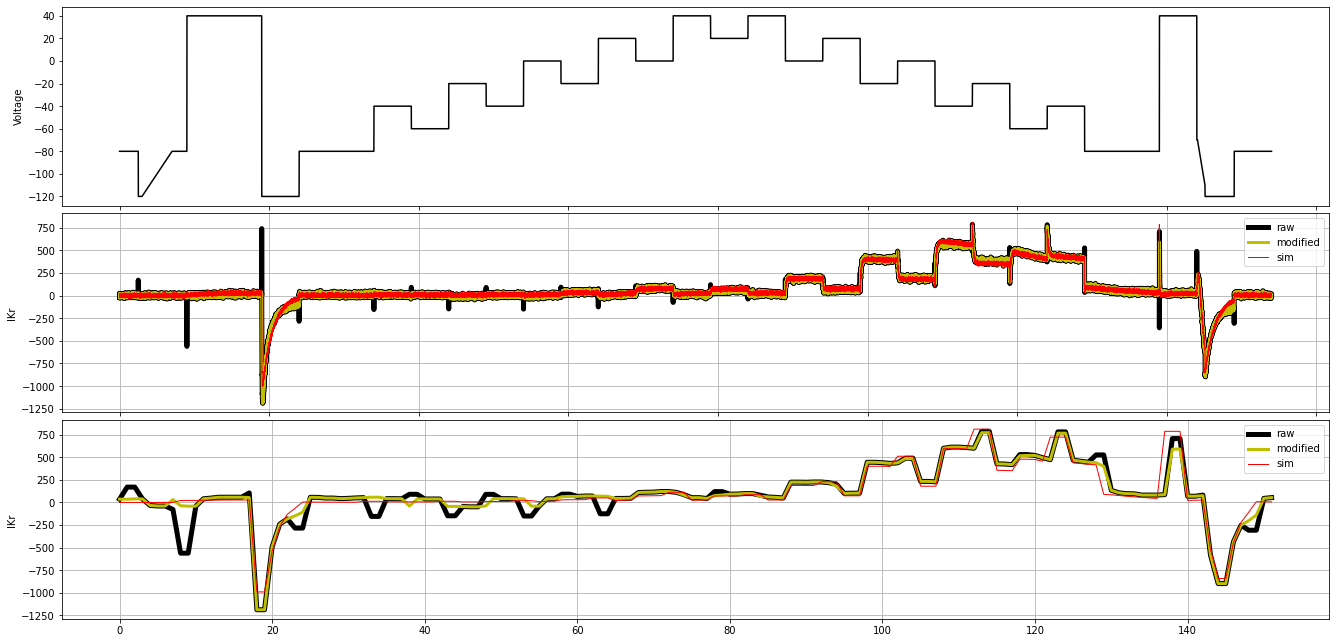

--- 2.1517937183380127 seconds ---


In [19]:
start_time = time.time()

for i in np.arange(1) : #np.random.randint(0, len(modified_current), size=5 ) # [1, 3, 4, 5, 6, 7]:    
    show_results(is_plot=True, index=i)    
    
print("--- %s seconds ---"%(time.time()-start_time))

In [20]:
# start_time = time.time()

# save_indices = np.arange(211) #np.random.randint(0, len(modified_current), size=5 ) # [1, 3, 4, 5, 6, 7]

# pool = multiprocessing.Pool(processes=os.cpu_count())
# func = partial(show_results, False)
# pool.map(func, save_indices)
# pool.close()
# pool.join()

# print("--- %s seconds ---"%(time.time()-start_time))